# Postprocessing

In [1]:
from os.path import join as pjoin
import sys 
sys.path.append('/home/hhansen/DecontextEmbeddings')
import os 
os.environ['EMBEDDING_EVALUATION_DATA_PATH'] = '/home/hhansen/DecontextEmbeddings/helpers/embedding_evaluation/data/'
DATA_DIR = '/home/hhansen/DecontextEmbeddings/data'
os.environ['DATA_DIR'] = DATA_DIR
FIGURE_OUTPUT_DIR = pjoin(DATA_DIR, 'figures', 'all_but_the_top')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from helpers.embedding_evaluation.evaluate import Evaluation as wordsim_evaluate
from helpers.embedding_evaluation.data import read_wordsim_embeddings
from helpers.things_evaluation.evaluate import read_embeddings, load_behav, load_sorting, match_behv_sim, evaluate as run_evaluation
from helpers.data import yield_static_data
from helpers.intersection import get_intersection_words
from helpers.plot import get_ax, set_style_and_font_size, model_prettify

set_style_and_font_size()

from scipy.stats import spearmanr, pearsonr
from collections import defaultdict
import os 
from copy import deepcopy
import numpy as np

/home/hhansen/decon/decon_env/DecontextEmbeddings/data


In [2]:
def plot(combs, results, results_anistropy_cleaned, title):
    fig, axes = plt.subplots(1,2, figsize=(10,5), sharey= True)

    for i, _ in enumerate(combs.items()):
        ax = axes[i]
        model, n_context_mapping = _
        for n_context, layers in n_context_mapping.items():
            layers = [str(layer) for layer in layers]            
            label = 'Decontextualized' if n_context == 'all' else 'Contextualized'
            c = 'C0' if n_context == 'all' else 'C1'
            ax.plot(layers, results[model][n_context], marker='o', label=label + ' - without postprocessing', linestyle='dotted', c=c)
            ax.plot(layers, results_anistropy_cleaned[model][n_context], marker='o', label=label + ' - with postprocessing', c=c)

        ax.set_xticks(layers)
        
        if 'w2v' in results_anistropy_cleaned.keys():
            ax.axhline(results_anistropy_cleaned['w2v'], label='Word2Vec - with postprocessing', c='C3')
            ax.axhline(results['w2v'], label='Word2Vec - without postprocessing', linestyle='dotted', c='C3')
        
        ax.set_title(f'{model_prettify(model)}')

    ax = axes[0]
    ax.legend()
    ax.set_xlabel('Extraction layer')
    ax.set_ylabel('Spearman correlation')

    plt.tight_layout()
    plt.savefig(pjoin(FIGURE_OUTPUT_DIR, f'abtt_{title}.pdf'), bbox_inches='tight')

In [3]:
def isotropy(embeddings):
    embeddings_np = embeddings.to_numpy()

    mean_normalized = embeddings_np - np.mean(embeddings_np, axis=0)

    D = int(mean_normalized.shape[1] / 100)
    u = PCA(n_components=D).fit(mean_normalized).components_ 
    
    print(mean_normalized.shape)
    print(u.shape)
    
    isotropy_embeddings = mean_normalized - (embeddings_np @ u.T @ u)  
    
    return pd.DataFrame(isotropy_embeddings, index=embeddings.index)

# THINGS

In [4]:
combs = {
    'bert-base': {
        '1': range(13),
        'all': range(13)
    },
    'gpt-2': {
        '1': range(13),
        'all': range(13)
    }
}

In [5]:
corpus = 'wikidumps'
matching = 'word'
results = defaultdict(lambda: defaultdict(list))
results_anistropy_cleaned = defaultdict(lambda: defaultdict(list))

matching_words_things = get_intersection_words(1, matching=matching, corpus_folder=corpus, folder='thinga')
print(f'use {len(matching_words_things)} for things')
   
for model, embedding_path, static_matching in yield_static_data('thinga'):
    df = read_embeddings(embedding_path, matching=static_matching, matching_words=matching_words_things)
    pearson, spearman, matrix, vector = run_evaluation(df, matching=static_matching, matching_words=matching_words_things)
    results[model] = spearman.correlation

    pearson, spearman, matrix, vector = run_evaluation(isotropy(df), matching)
    results_anistropy_cleaned[model] = spearman.correlation
        
for model, n_context_mapping in combs.items():
    for n_context, layers in n_context_mapping.items():
        for layer in layers:
            path = f'{EMBEDDING_DATA_DIR}/thinga/{corpus}/decontext/{model}/{layer}/{matching}/mean/{n_context}/decontext.txt'
            df = read_embeddings(path, matching=matching, matching_words=matching_words_things)
            pearson, spearman, matrix, vector = run_evaluation(df, matching)
            results[model][n_context].append(spearman.correlation)
                
            pearson, spearman, matrix, vector = run_evaluation(isotropy(df), matching)
            results_anistropy_cleaned[model][n_context].append(spearman.correlation)
    

('w2v', '/home/hhansen/decon/decon_env/data/thinga/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
('glove', '/home/hhansen/decon/decon_env/data/thinga/static/glove/glove-wiki-gigaword-300/embeddings.txt', 'word')
('deconf', '/home/hhansen/decon/decon_env/data/thinga/static/deconf/embeddings.txt', 'synset')
Number of words intersection: 1522
use 1522 for things
('w2v', '/home/hhansen/decon/decon_env/data/thinga/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 300)
(3, 300)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'y

(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
   

Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
   

(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
   

Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
(1522, 768)
(7, 768)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
   

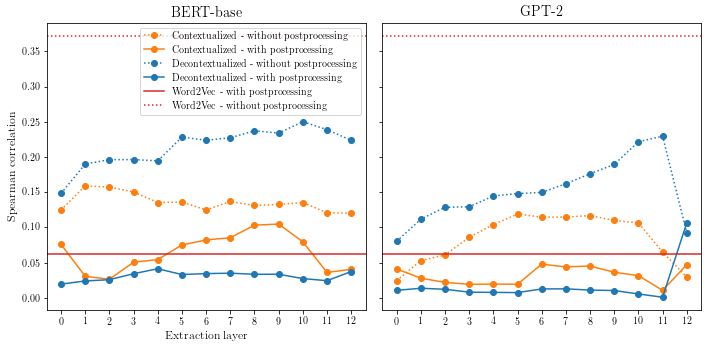

In [6]:
plot(combs, results, results_anistropy_cleaned, 'things')

# Simlex

In [7]:
def df_to_dict(df):
    embedding_dict = {}
    for row in df.iterrows():
        word = row[0]
        embedding = list(row[1])
        embedding_dict[word] = embedding
    return embedding_dict

In [8]:
corpus = 'wikidumps'
matching = 'word'
results = defaultdict(lambda: defaultdict(list))
results_anistropy_cleaned = defaultdict(lambda: defaultdict(list))

matching_words = get_intersection_words(1, matching=matching, corpus_folder=corpus, folder='word_sim')
print(f'use {len(matching_words)} for wordsim')
   
for model, embedding_path, static_matching in yield_static_data('word_sim'):
    print(model)
    embeddings = read_wordsim_embeddings(embedding_path, matching_words, matching=static_matching, as_df=True)
    evaluation = wordsim_evaluate() 
    eval_results = evaluation.evaluate(df_to_dict(embeddings))
    spearman_simlex = eval_results['similarity']['simlex']['all_entities']
    results[model] = spearman_simlex

    eval_results = evaluation.evaluate(df_to_dict(isotropy(embeddings)))
    spearman_simlex = eval_results['similarity']['simlex']['all_entities']
    results_anistropy_cleaned[model] = spearman_simlex
        
for model, n_context_mapping in combs.items():
    print(model)
    for n_context, layers in n_context_mapping.items():
        for layer in layers:
            path = f'{EMBEDDING_DATA_DIR}/word_sim/{corpus}/decontext/{model}/{layer}/{matching}/mean/{n_context}/decontext.txt'
            embeddings = read_wordsim_embeddings(path, matching_words, matching=matching, as_df=True)
            evaluation = wordsim_evaluate() 
            eval_results = evaluation.evaluate(df_to_dict(embeddings))
            spearman_simlex = eval_results['similarity']['simlex']['all_entities']
            results[model][n_context].append(spearman_simlex)

            eval_results = evaluation.evaluate(df_to_dict(isotropy(embeddings)))
            spearman_simlex = eval_results['similarity']['simlex']['all_entities']
            results_anistropy_cleaned[model][n_context].append(spearman_simlex)
    

('w2v', '/home/hhansen/decon/decon_env/data/word_sim/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
('glove', '/home/hhansen/decon/decon_env/data/word_sim/static/glove/glove-wiki-gigaword-300/embeddings.txt', 'word')
('deconf', '/home/hhansen/decon/decon_env/data/word_sim/static/deconf/embeddings.txt', 'synset')
Number of words intersection: 1323
use 1323 for wordsim
('w2v', '/home/hhansen/decon/decon_env/data/word_sim/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
w2v
simlex
ws353
(1323, 300)
(3, 300)
simlex
ws353
('glove', '/home/hhansen/decon/decon_env/data/word_sim/static/glove/glove-wiki-gigaword-300/embeddings.txt', 'word')
glove
simlex
ws353
(1323, 300)
(3, 300)
simlex
ws353
('deconf', '/home/hhansen/decon/decon_env/data/word_sim/static/deconf/embeddings.txt', 'synset')
deconf
simlex
ws353
(1323, 300)
(3, 300)
simlex
ws353
bert-base
simlex
ws353
(1323, 768)
(7, 768)
simlex
ws353
simlex
ws353
(1323, 768)
(7, 768)
simlex
ws353
simlex
ws353
(1323, 768)
(

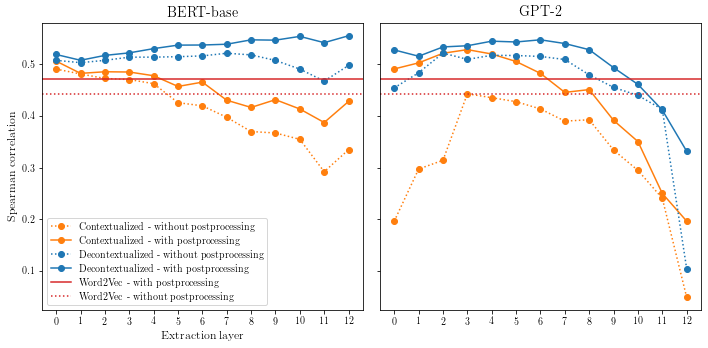

In [9]:
plot(combs, results, results_anistropy_cleaned, 'wordsim')

# THINGS  - Retrained

In [10]:
def plot_retrain(combs, results, results_anistropy_cleaned, title):
    fig, ax = plt.subplots(1,1, figsize=(5,5), sharey= True)

    for i, _ in enumerate(combs.items()):
        model, n_context_mapping = _
        for n_context, layers in n_context_mapping.items():
            layers = [str(layer) for layer in layers]            
            c = 'C0' if n_context == 'all' else 'C1'
            ax.plot(layers, results[model][n_context], marker='o', label='without postprocessing', linestyle='dotted', c=c)
            ax.plot(layers, results_anistropy_cleaned[model][n_context], marker='o', label='with postprocessing', c=c)

        ax.set_xticks(layers)
        ax.set_title(f'{model_prettify(model)}')

    ax.legend()
    ax.set_xlabel('Extraction layer')
    ax.set_ylabel('Spearman correlation')

    plt.tight_layout()
    plt.savefig(pjoin(FIGURE_OUTPUT_DIR, f'abtt_{title}_retrain.pdf'), bbox_inches='tight')

In [11]:
combs = {
    'bert-base': {
        'all': range(13)
    }
}

In [ ]:
corpus = 'wikidumps'
matching = 'word'
retrain_results = defaultdict(lambda: defaultdict(list))
retrain_results_anistropy_cleaned = defaultdict(lambda: defaultdict(list))

matching_words_things = get_intersection_words(1, matching=matching, corpus_folder=corpus, folder='thinga')
print(f'use {len(matching_words_things)} for things')
        
for model, n_context_mapping in combs.items():
    for n_context, layers in n_context_mapping.items():
        for layer in layers:
            path = f'{RETRAIN_EMBEDDING_DATA_DIR}/things/{corpus}/decontext/{model}/{layer}/{matching}/mean/{n_context}/constrastive_loss.txt'
            df = read_embeddings(path, matching=matching, matching_words=matching_words_things)
            pearson, spearman, matrix, vector = run_evaluation(df, matching)
            retrain_results[model][n_context].append(spearman.correlation)
                
            pearson, spearman, matrix, vector = run_evaluation(isotropy(df), matching)
            retrain_results_anistropy_cleaned[model][n_context].append(spearman.correlation)
    

('w2v', '/home/hhansen/decon/decon_env/data/thinga/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
('glove', '/home/hhansen/decon/decon_env/data/thinga/static/glove/glove-wiki-gigaword-300/embeddings.txt', 'word')
('deconf', '/home/hhansen/decon/decon_env/data/thinga/static/deconf/embeddings.txt', 'synset')


In [ ]:
plot_retrain(combs, retrain_results, retrain_results_anistropy_cleaned, 'things_retrained')